# Ray start/stop

In [ ]:
ray.init(ignore_reinit_error=True)

In [ ]:
import ray
ray.shutdown()

# Imports

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")

import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3
import bar_samples as bs
import bar_labels as bl
import bar_workflow as bw
import utils_filters as ft
from utils_pickle import pickle_dump, pickle_load

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# set sampling params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# rw, outlier_ind = ft.random_walk_with_outliers(0, 1000, 0.01)
# plt.plot(np.arange(len(rw)), rw)
# plt.scatter(outlier_ind, rw[outlier_ind], c='r', label='outlier')
# plt.title('Random Walk with outliers')
# plt.xlabel('Time steps')
# plt.ylabel('Values')
# plt.legend();

In [ ]:
df = ft.mad_filter_batch(ticks_df)

In [ ]:
from bokeh.plotting import figure, output_file, show, output_notebook

# output_notebook()

x = df.index
y = df.price

x2 = df[df.mad_outlier==True].index
y2 = df[df.mad_outlier==True].price

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

p1 = figure(title="Legend Example", tools=TOOLS)

p1.line(x,   y)
p1.circle(x2, y2, legend_label="outlier", color="orange")

# output_file("legend.html", title="legend.py example")

show(p1, sizing_mode="scale_height")  # open a browser

In [ ]:
df.price_median_diff_median.plot()


# Sample tick dates

In [79]:
# set sampling params
symbol = 'VTI'
start_date = '2020-11-08'
end_date = '2020-11-09'
date = '2020-11-19'

thresh = {
    # max thresholds
    'renko_return': 'jma_return',
    'renko_size': 0.1,
    'renko_reveral_multiple': 2,
    'renko_range_frac': 20,
    'max_duration_sec': 60*60*0.5,  # 1/2 hour
    # min thresholds
    'min_duration_sec': 10,
    'min_tick_count': 30,
    # label params
    'label_reward_ratios': list(np.arange(2, 11, 0.5)),
}

ray_on = False

if ray_on:
    import ray
    ray.init(ignore_reinit_error=True)


In [114]:
symbol = 'VTI'
date = '2020-11-19'

ticks_df = ps3.fetch_date_df(symbol, date, tick_type='trades')

bars, ticks, bar_state = bs.build_bars(ticks_df, thresh)

bdf = pd.DataFrame(bars)
tdf = pd.DataFrame(ticks)

tdf.status.value_counts()/tdf.shape[0]

VTI 2020-11-19 trying to get data from local file...


clean                 0.982674
mad_outlier           0.007501
irregular_condition   0.006930
ts_delta              0.002772
zero_volume           0.000122
Name: status, dtype: float64

In [121]:
from datetime import timedelta

In [122]:
bar_state['stat']['duration_td'] > timedelta(hours=1)

False

In [109]:
bdf.duration_min.describe()

count    81.000000
mean      9.347325
std      19.993585
min       0.166667
25%       1.466667
50%       3.233333
75%       7.983333
max     141.366667
Name: duration_min, dtype: float64

<AxesSubplot:>

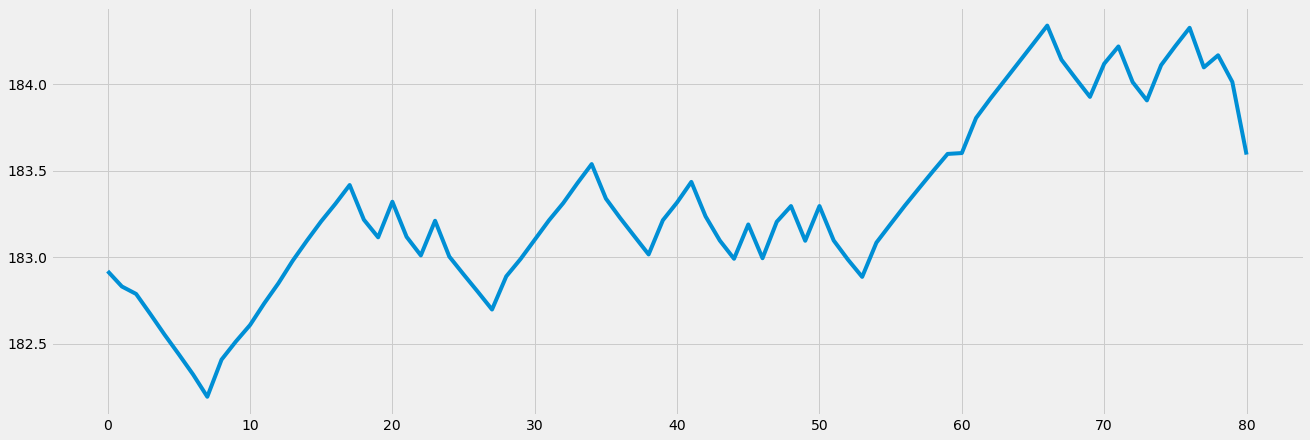

In [104]:
bdf.jma_close.plot()

<AxesSubplot:xlabel='date_time'>

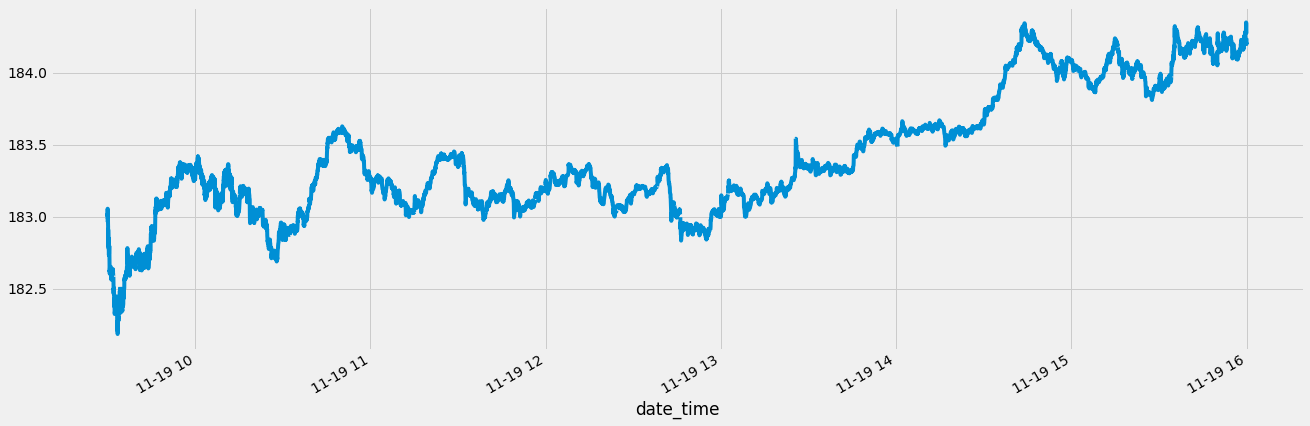

In [81]:
tdf.set_index('date_time').between_time(start_time='9:30', end_time='16:00').jma.plot()

<AxesSubplot:>

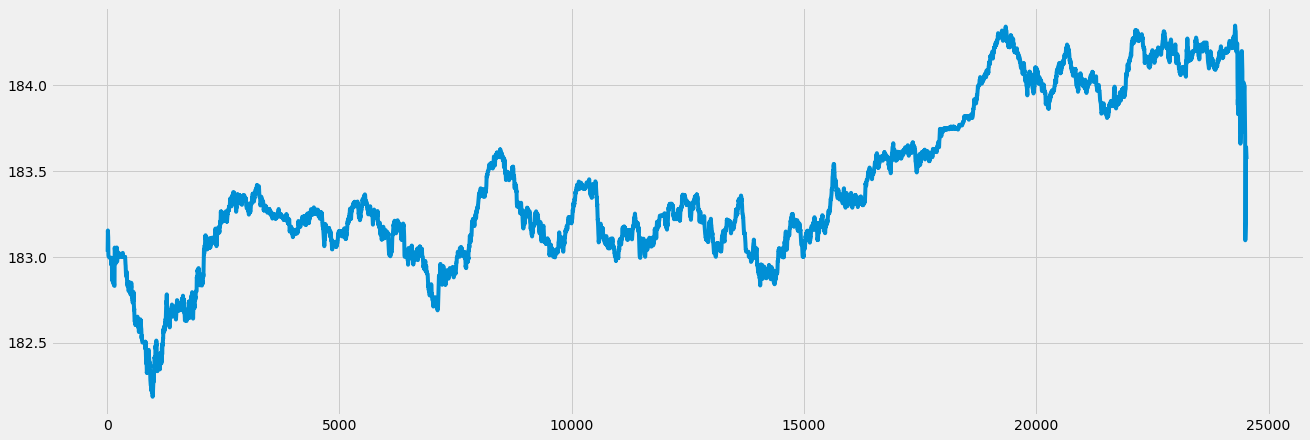

In [82]:
tdf[tdf.status=='clean'].jma.plot()

<AxesSubplot:xlabel='date_time'>

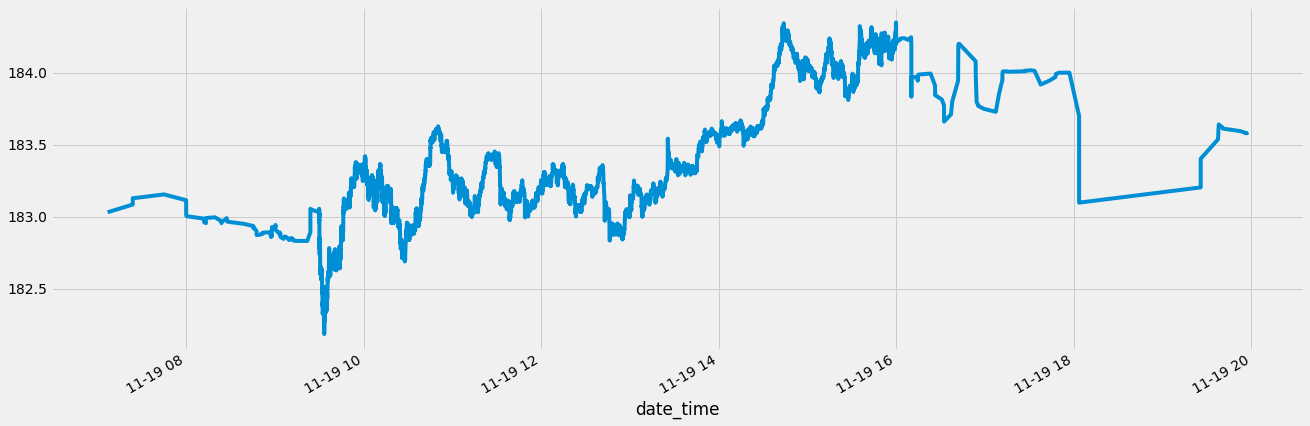

In [83]:
tdf[tdf.status=='clean'].set_index('date_time').jma.plot()

In [ ]:
results = []

for date in bar_dates:
    out = (date['ticks_df'].status.value_counts() / date['ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    results.append(out)
